# Deep Q-Network Variant Hindsight Replay DQN (HER-DQN) implementation (PyTorch).

In this notebook, we will implement HER-DQN variant of DQN. We saw DQN in `6.a_dqn_pytorch.ipynb`. We will borrow some parts of it. However, in this notebook we will create a different environment which has no reward till you hit the target - an example of sparse reward setup. We will see how the approach of HER helps us make it efficient to learn in the sparse reward setup. 

### RECAP

Q Learning control is carried out by sampling step by step and updating Q values at each step. We use $\epsilon$-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. We can carryout updates online i.e. we take a step and use `(current state, action, reward and next_state)` tuple to update.

In case of function approximation using neural network, the input to the network is the state and output is the $q(s,a)$ for all the actions in the state $s$. It is denoted as $ \hat{q}(s_t, a_t; w_{t}) $, where $w_{t}$ is the weigths of the neural network that we learn as part of DQN learning.

We use two networks, one target network with weight $w^-_t$ to get the max $q$-value of next state with best action denoted by $ \max\limits_a \hat {q}(S_{t+1},a; w^{-}_{t}) $ and network with weights $w_t^-$ which we periodically updated from primary network $w_t$.

The Update equation is given below. This is the online version:
$$ w_{t+1} \leftarrow w_t + \alpha [ R_{t+1} + \gamma . \max_{a} \hat{q}(S_{t+1},a;w^{-}_{t}) – \hat{q}(S_t,A_t;w_t)] \nabla_{w_t} \hat{q}(S_t,A_t;w_t)$$

Online update with neural network with millions of weights does not work well. Accordingly, We use experience replay (aka Replay Buffer).  We use a behavior policy to explore the environment and store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using q-values.

Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. This process makes learning sample efficient by reusing a sample multiple times and also removing temporal dependence of the samples we would otherwise see while following a trajectory.

The update equation with batch update with minor modifications is given below. We collect samples of transitions `(current state, action, reward, next state)` in a buffer, where each sample is denoted as a tuple:

$$ (s_{i}, a_{i}, r_{i}, s'_{i}, done_{i})$$

Subscript ($i$) denotes ith sample. We take $N$ samples from experience replay selecting randomly and update the weights. Subscript ($t$) denotes the index of weight updates. If the current state is done, as denoted by `done` flag, the target is just the reward as terminal states have zero value. The final update equation is as given below:

$$w_{t+1} \leftarrow w_t + \alpha \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_{i},a';w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla_{w_t} \hat{q}(s_i,a_i;w_t)$$


#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [1]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab

# !apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
# !pip install box2d-py
# !pip install "stable-baselines3[extra]>=2.1"
# !pip install "huggingface_sb3>=3.0"

# !pip install git+https://github.com/DLR-RM/rl-baselines3-zoo@update/hf
# !git clone https://github.com/DLR-RM/rl-baselines3-zoo
# %cd rl-baselines3-zoo/
# !pip install -r requirements.txt
# %cd ..


### Imports

In [2]:
import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from base64 import b64encode
import time
from tqdm import trange
import glob
from collections import namedtuple

from IPython.display import HTML, clear_output

%matplotlib inline

2023-12-16 16:41:57.066879: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-16 16:41:57.070524: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 16:41:57.123044: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 16:41:57.123172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 16:41:57.123224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Experience replay

We will use the replay buffer we saw in chapter 4 listings. Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon$-greedy) to sample from the environment and store the transitions `(s,a,r,s',done)` into a buffer. These samples are used multiple times in a learning making the process sample efficient.

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

We have modified the implementation a bit to make it more efficient

In [4]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to holde buffer
        self.next_id = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
           self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)

### Learning with DQN
Here we write a function similar to tabular q-learning. We will calculate average TD error per batch using the equation:

$$ L =  \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_i,a';w^-_t) \right) – \hat{q}_{w_t}(s_i,a_i;w_t) \right]^2$$


$$ \nabla_{w_t} L =   - \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_i,a';w^-_t) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}_{w_t}(s_i,a_i;w_t)$$


$\hat{q}(s',a';w^{-})$ is calculated using target network whose weights are held constant and refreshed periodically from the agent learning network.

Target is given by following:
* non terminal state: $r_i +  \gamma .  \max\limits_{a'} \hat{q}(s'_i,a';w^-_t)$
* terminal state: $ r_i $

We then carryout back propagation through the agent network to update the weights using equation below:


$$
w_{t+1} \leftarrow w_t - \alpha . \nabla_{w_t}L$$

In [5]:
def td_loss_dqn(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma=0.99, device=device):

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute Qmax(next_states, actions) using predicted next q-values
    next_state_values,_ = torch.max(predicted_next_qvalues, dim=1)

    # compute "target q-values"
    target_qvalues_for_actions = rewards + gamma * next_state_values * (1-done_flags)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    return loss

### Hindsight Replay

In the paper by OpenAI in 2018, https://arxiv.org/pdf/1707.01495.pdf, the authors presented a sample efficient approach to learn in the environment where the rewards are sparse and binary. The common approach is to shape the reward function in a way to guide the agents towards optimization. This is not generalizable. It requires a deep understanding of the domain to design a suitable reward function.

Compared to RL agents, which learn from a successful outcome, humans seem to learn not just from that but also from unsuccessful outcomes. This is the basis of the idea proposed in Hindsight replay approach known as **HER**. While **HER** can be combined with various RL approaches. In the code cells below we will use HER with Dueling DQN giving us **HER-DQN**

In HER approach, after an episode is played out which let us say was not successful, we form a secondary objective where the original goal is replaced with the last state before termination as a goal for this trajectory since this trajectory ended in that state. 

Say a episode has been played out $ s_0, s_1, .... s_T$. Normally we store in Replay buffer a tuple of $(s_t, a_t, r, s_{t+1}, done)$. Let us say the goal for this episode was $g$ which could not be achieved in this run. In HER approach we will store following to the replay buffer:

* $(s_t||g, a_t, r, s_{t+1}||g, done)$
* $(s_t||g', a_t, r(s_t, a_t, g'), s_{t+1}||g', done)$: other state transitions based on synthetic goals like last state of the episode as a sub-goal say g'. The reward is modified to show how state transition $s_t \rightarrow s_{t+1}$, was good or bad for the sub-goal of $g'$. 

Original paper discusses various strategies for forming these subgoals. We will use one of them called `future`:
* future — replay with k random states which come from the same episode as the transition being replayed and were observed after it.

We also use a different kind of environment from our past notebooks. We will use an environment as used in the paper that of bit-flipping experiment. Say you have a vector with n-bits, each being binary in the range {0,1}. Therefore there are $2^n$ combinations possible. At reset, environment starts in a n-bit configuration randomly and the goal is also randomly picked to be some different n-bit configuration. Each action is to flip a bit. The bit to be flipped is the policy $\pi(a|s)$ that agent is trying to learn. An episode ends if the agent is able to find the right configuration matching the goal or when agent has exhausted `n` actions in an episode.

The authors show that a regular DQN, where the state (configuration of n-bits) is represented as a deep network, it is almost impossible for a regular DQN agent to learn beyond 15 digit combinations. However, coupled with HER-DQN approach, the agent is able to learn easily even for large digit combinations like 50 or so. 


In [6]:
class BitFlipEnvironment:

    def __init__(self, bits):
        self.bits = bits
        self.state = np.zeros((self.bits, ))
        self.goal = np.zeros((self.bits, ))
        self.reset()

    def reset(self):
        self.state = np.random.randint(2, size=self.bits).astype(np.float32)
        self.goal = np.random.randint(2, size=self.bits).astype(np.float32)
        if np.allclose(self.state, self.goal):
            self.reset()
        return self.state.copy(), self.goal.copy()

    def step(self, action):
        self.state[action] = 1 - self.state[action]  # Flip the bit on position of the action
        reward, done = self.compute_reward(self.state, self.goal)
        return self.state.copy(), reward, done

    def render(self):
        print("State: {}".format(self.state.tolist()))
        print("Goal : {}\n".format(self.goal.tolist()))

    @staticmethod
    def compute_reward(state, goal):
        done = np.allclose(state, goal)
        return 0.0 if done else -1.0, done

# a simplified version of DuelingDQN with lesser number of layers
class DuelingMLP(nn.Module):

    def __init__(self, state_size, n_actions, epsilon=1.0):
        super().__init__()
        self.state_size = state_size
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.linear = nn.Linear(state_size, 256)
        self.v = nn.Linear(256, 1)
        self.adv = nn.Linear(256, n_actions)

    def forward(self, x):
        x = F.relu(self.linear(x))
        v = self.v(x)
        adv = self.adv(x)
        qvalues = v + adv - adv.mean(dim=1, keepdim=True)
        return qvalues
    
    def get_qvalues(self, states):
        # input is an array of states in numpy and output is Qvals as numpy array
        states = torch.tensor(np.array(states), device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape        
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)



In [7]:
def train_her(env, agent, target_network, optimizer, td_loss_fn):

    success_rate = 0.0
    success_rates = []
    
    exp_replay = ReplayBuffer(10**6)
    
    for epoch in range(num_epochs):

        # Decay epsilon linearly from eps_max to eps_min
        eps = max(eps_max - epoch * (eps_max - eps_min) / int(num_epochs * exploration_fraction), eps_min)
        print("Epoch: {}, exploration: {:.0f}%, success rate: {:.2f}".format(epoch + 1, 100 * eps, success_rate))
        agent.epsilon = eps
        target_network.epsilon = eps

        successes = 0
        for cycle in range(num_cycles):

            for episode in range(num_episodes):

                # Run episode and cache trajectory
                episode_trajectory = []
                state, goal = env.reset()

                for step in range(num_bits):

                    state_ = np.concatenate((state, goal))
                    qvalues = agent.get_qvalues([state_])
                    action = agent.sample_actions(qvalues)[0]
                    next_state, reward, done = env.step(action)
                    
                    episode_trajectory.append((state, action, reward, next_state, done))
                    state = next_state
                    if done:
                        successes += 1
                        break

                # Fill up replay memory
                steps_taken = step
                for t in range(steps_taken):

                    # Usual experience replay
                    state, action, reward, next_state, done = episode_trajectory[t]
                    state_, next_state_ = np.concatenate((state, goal)), np.concatenate((next_state, goal))
                    exp_replay.add(state_, action, reward, next_state_, done)

                    # Hindsight experience replay
                    for _ in range(future_k):
                        future = random.randint(t, steps_taken)  # index of future time step
                        new_goal = episode_trajectory[future][3]  # take future next_state from (s,a,r,s',d) and set as goal
                        new_reward, new_done = env.compute_reward(next_state, new_goal)
                        state_, next_state_ = np.concatenate((state, new_goal)), np.concatenate((next_state, new_goal))
                        exp_replay.add(state_, action, new_reward, next_state_, new_done)

            # Optimize DQN
            for opt_step in range(num_opt_steps):
                # train by sampling batch_size of data from experience replay
                states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)
                # loss = <compute TD loss>
                optimizer.zero_grad()
                loss = td_loss_fn(agent, target_network, 
                                  states, actions, rewards, next_states, done_flags,                  
                                  gamma=0.99,
                                  device=device)
                loss.backward()
                optimizer.step()
        
            target_network.load_state_dict(agent.state_dict())

        success_rate = successes / (num_episodes * num_cycles)
        success_rates.append(success_rate)

    # print graph
    plt.plot(success_rates, label="HER-DQN")

    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Success rate")
    plt.title("Number of bits: {}".format(num_bits))
    plt.show()

In [8]:
num_bits = 50 
n_actions = num_bits
state_size = 2*num_bits

future_k = 4
num_epochs = 40
num_cycles = 50
num_episodes = 16
num_opt_steps = 40
eps_max=0.2
eps_min=0.0
exploration_fraction=0.5
batch_size = 128


env = BitFlipEnvironment(num_bits)

agent = DuelingMLP(state_size, n_actions, epsilon=1).to(device)
target_network = DuelingMLP(state_size, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-3)

Epoch: 1, exploration: 20%, success rate: 0.00
Epoch: 2, exploration: 19%, success rate: 0.00
Epoch: 3, exploration: 18%, success rate: 0.00
Epoch: 4, exploration: 17%, success rate: 0.00
Epoch: 5, exploration: 16%, success rate: 0.00
Epoch: 6, exploration: 15%, success rate: 0.00
Epoch: 7, exploration: 14%, success rate: 0.00
Epoch: 8, exploration: 13%, success rate: 0.01
Epoch: 9, exploration: 12%, success rate: 0.03
Epoch: 10, exploration: 11%, success rate: 0.04
Epoch: 11, exploration: 10%, success rate: 0.09
Epoch: 12, exploration: 9%, success rate: 0.15
Epoch: 13, exploration: 8%, success rate: 0.21
Epoch: 14, exploration: 7%, success rate: 0.29
Epoch: 15, exploration: 6%, success rate: 0.43
Epoch: 16, exploration: 5%, success rate: 0.52
Epoch: 17, exploration: 4%, success rate: 0.63
Epoch: 18, exploration: 3%, success rate: 0.75
Epoch: 19, exploration: 2%, success rate: 0.81
Epoch: 20, exploration: 1%, success rate: 0.89
Epoch: 21, exploration: 0%, success rate: 0.92
Epoch: 22, 

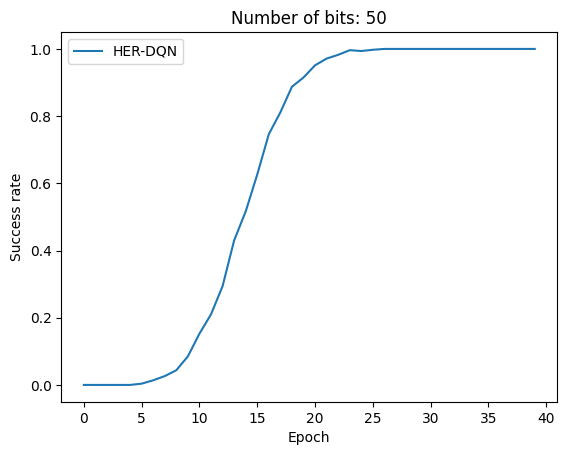

In [9]:
train_her(env, agent, target_network, optimizer, td_loss_fn=td_loss_dqn)

### Summary

In this notebook we saw how to train a DQN agent with experience replay and target networks. We also saw HER variant which augmented replay buffer with additional sub goals to make it sample efficient **Hindsight Experience Replay (HER-DQN)**. While we combined HER with DQN, it could also be combined with various other learning algorithms including ones from POlicy gradient versions from later chapters.
